In [29]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 50)

%config Completer.use_jedi = False

In [2]:
df = pd.read_csv('data/train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train, test = tml.make_test(df, 0.2, random_state=43, strat_feat=['Sex', 'Pclass'])
print(round(len(train) / len(df) * 100, 2))
print(round(len(test) / len(df) * 100, 2))
train.head()

79.91
20.09


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
144,145,0,2,"Andrew, Mr. Edgardo Samuel",male,18.0,0,0,231945,11.5000,NaN,S
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
56,57,1,2,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q


# Data Exploration

In [9]:
tml.list_missing(train)
print('_'*40)
tml.list_missing(test)

Column Age: 19.66% missing
Column Cabin: 77.11% missing
Column Embarked: 0.14% missing
________________________________________
Column Age: 20.67% missing
Column Cabin: 77.09% missing
Column Embarked: 0.56% missing


['Age', 'Cabin', 'Embarked']

In [11]:
train.groupby('Pclass').Survived.mean()

Pclass
1    0.647399
2    0.462585
3    0.244898
Name: Survived, dtype: float64

In [12]:
train.groupby('Sex').Survived.mean()

Sex
female    0.733068
male      0.199566
Name: Survived, dtype: float64

In [13]:
train.groupby(['Pclass', 'Sex']).Survived.mean().unstack()

Sex,female,male
Pclass,,
1,0.973333,0.397959
2,0.918033,0.139535
3,0.478261,0.148014


In [16]:
def check_missing(data, feature):
    print(data[data[feature].isna()].Survived.mean())
    print(data[data[feature].notna()].Survived.mean())
    
check_missing(train, 'Age')
print('_'*40)
check_missing(train, 'Cabin')
print('_'*40)
check_missing(train, 'Embarked')

0.29285714285714287
0.41083916083916083
________________________________________
0.29690346083788705
0.6932515337423313
________________________________________
1.0
0.38677918424753865


# Baselines

Everybody dies

In [19]:
print(round(accuracy_score(y_pred=[0]*len(train), y_true=train.Survived)*100, 3))
print(round(accuracy_score(y_pred=[0]*len(test), y_true=test.Survived)*100, 3))

61.236
63.128


Women surviving

In [20]:
tr_pred = np.where(train.Sex == 'female', 1, 0)
te_pred = np.where(test.Sex == 'female', 1, 0)

print(round(accuracy_score(y_pred=tr_pred, y_true=train.Survived)*100, 3))
print(round(accuracy_score(y_pred=te_pred, y_true=test.Survived)*100, 3))

77.669
82.682


Everybody in third class dies

In [21]:
tr_pred = np.where(train.Pclass < 3, 1, 0)
te_pred = np.where(test.Pclass < 3, 1, 0)

print(round(accuracy_score(y_pred=tr_pred, y_true=train.Survived)*100, 3))
print(round(accuracy_score(y_pred=te_pred, y_true=test.Survived)*100, 3))

66.854
66.48


# Model Selection

## No processing

In [47]:
train_feats = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']

kfolds = KFold(n_splits=5, random_state=409, shuffle=True)

y = train.Survived

In [48]:
def compare_models(data, target, models, cv, processing=None):
    for model in models:
        print(model[0])
        
        if processing is not None:
            model_pipe = Pipeline([('processing', processing), model])
        else:
            model_pipe = model[1]
        
        if not model[0] in ['xgb', 'lgb']: 
            oof, _ = tml.cv_score(data=data, target=target, estimator=model_pipe, cv=cv, predict_proba=True)
        else:
            oof, _ = tml.cv_score(data=data, target=target, estimator=model_pipe, cv=cv, predict_proba=True, 
                               early_stopping=50, eval_metric='auc')
        
        tml.eval_classification(data, target, oof, proba=True, thrs=0.5, plot=1, hue_feat='Sex', feat='Age')

logit


/home/lucabasa/Git/kaggle_competitions/titanic/titanic/lib/python3.8/site-packages/tubesml/report.py:129: UserWarning: The feature Age is not in the provided data, it will be ignored
  warnings.warn(f'The feature {feat} is not in the provided data, it will be ignored', UserWarning)


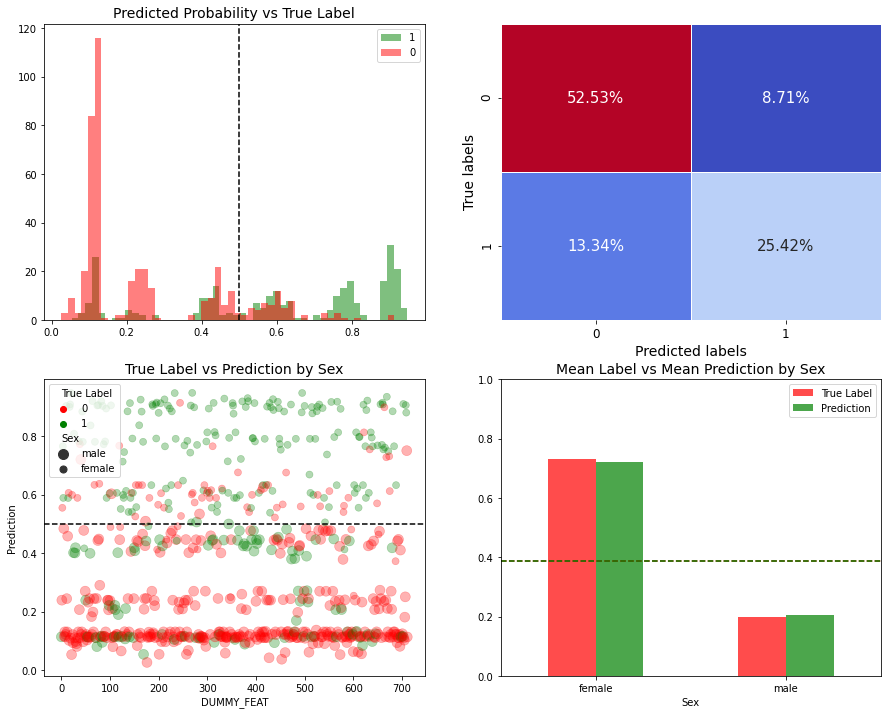

Accuracy score: 	0.7795
AUC ROC: 		0.8146
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       436
           1       0.74      0.66      0.70       276

    accuracy                           0.78       712
   macro avg       0.77      0.76      0.76       712
weighted avg       0.78      0.78      0.78       712

forest


/home/lucabasa/Git/kaggle_competitions/titanic/titanic/lib/python3.8/site-packages/tubesml/report.py:129: UserWarning: The feature Age is not in the provided data, it will be ignored
  warnings.warn(f'The feature {feat} is not in the provided data, it will be ignored', UserWarning)


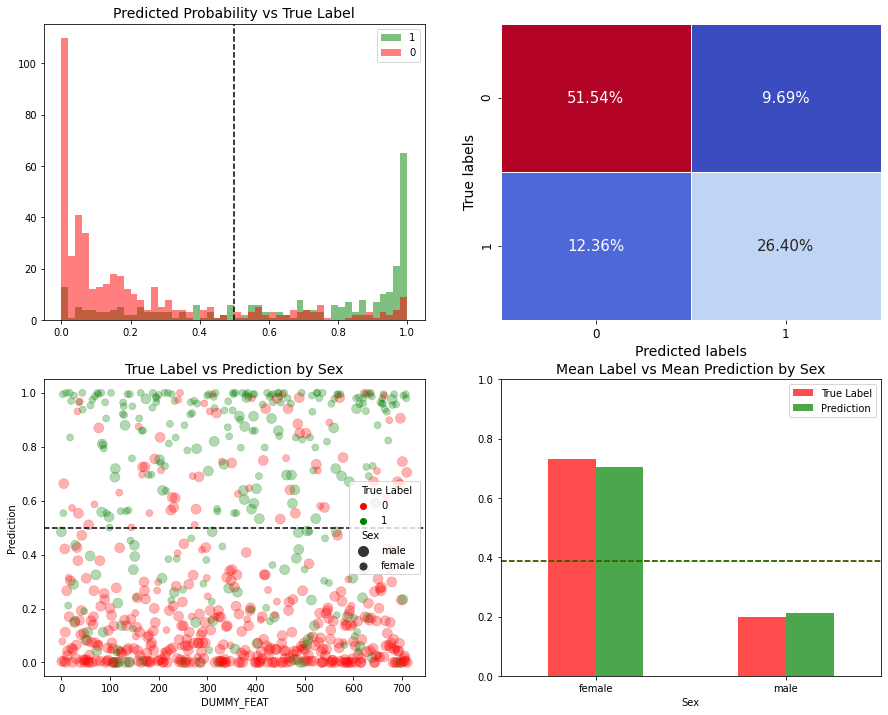

Accuracy score: 	0.7809
AUC ROC: 		0.8371
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       436
           1       0.73      0.68      0.71       276

    accuracy                           0.78       712
   macro avg       0.77      0.76      0.77       712
weighted avg       0.78      0.78      0.78       712

tree


/home/lucabasa/Git/kaggle_competitions/titanic/titanic/lib/python3.8/site-packages/tubesml/report.py:129: UserWarning: The feature Age is not in the provided data, it will be ignored
  warnings.warn(f'The feature {feat} is not in the provided data, it will be ignored', UserWarning)


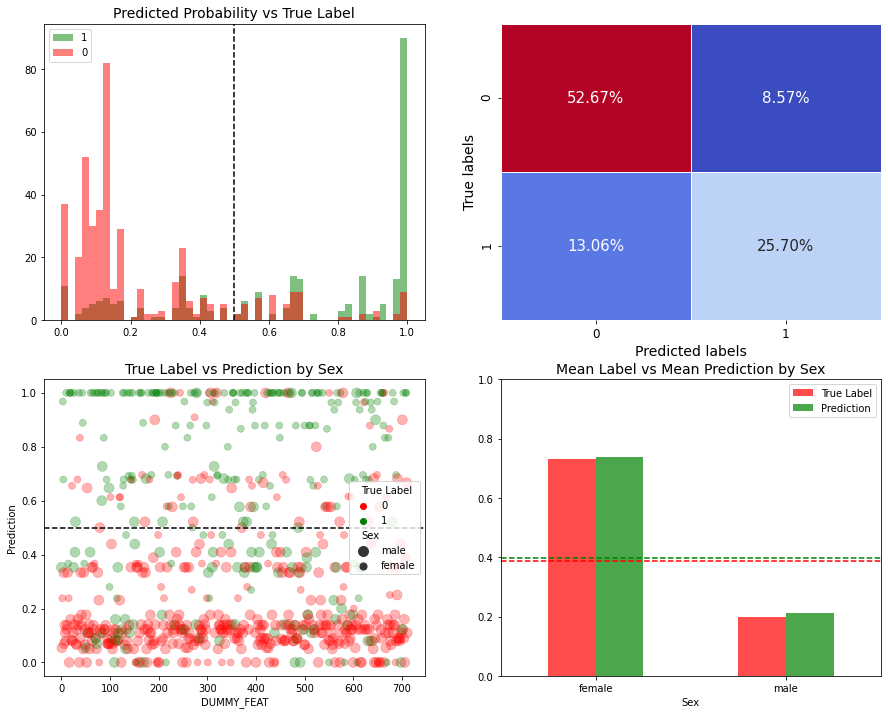

Accuracy score: 	0.7837
AUC ROC: 		0.8285
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       436
           1       0.75      0.67      0.71       276

    accuracy                           0.78       712
   macro avg       0.77      0.76      0.77       712
weighted avg       0.78      0.78      0.78       712

xgb


/home/lucabasa/Git/kaggle_competitions/titanic/titanic/lib/python3.8/site-packages/tubesml/report.py:129: UserWarning: The feature Age is not in the provided data, it will be ignored
  warnings.warn(f'The feature {feat} is not in the provided data, it will be ignored', UserWarning)


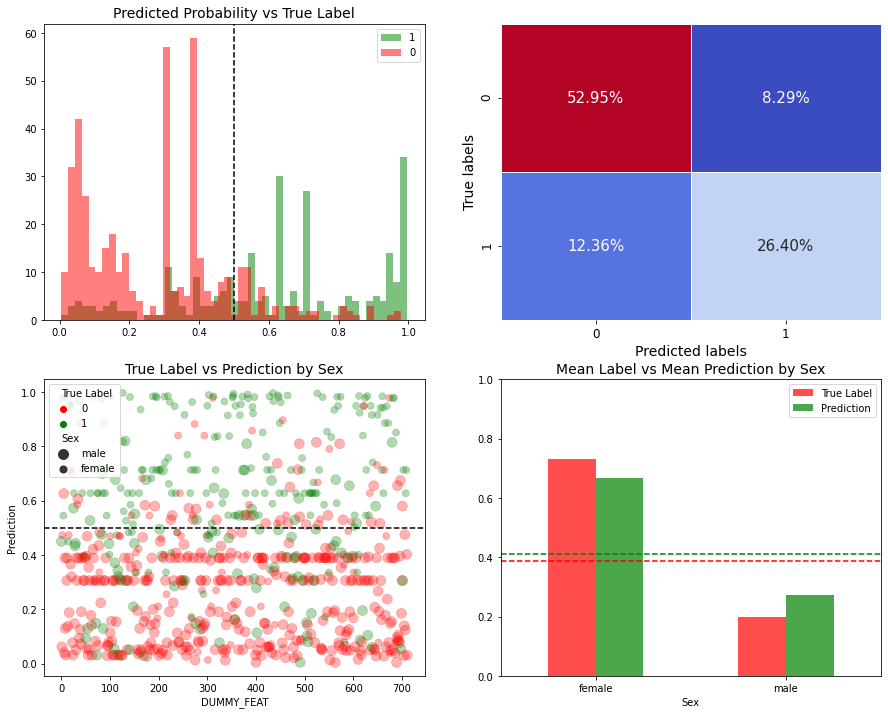

Accuracy score: 	0.7935
AUC ROC: 		0.8374
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       436
           1       0.76      0.68      0.72       276

    accuracy                           0.79       712
   macro avg       0.79      0.77      0.78       712
weighted avg       0.79      0.79      0.79       712

lgb


/home/lucabasa/Git/kaggle_competitions/titanic/titanic/lib/python3.8/site-packages/tubesml/report.py:129: UserWarning: The feature Age is not in the provided data, it will be ignored
  warnings.warn(f'The feature {feat} is not in the provided data, it will be ignored', UserWarning)


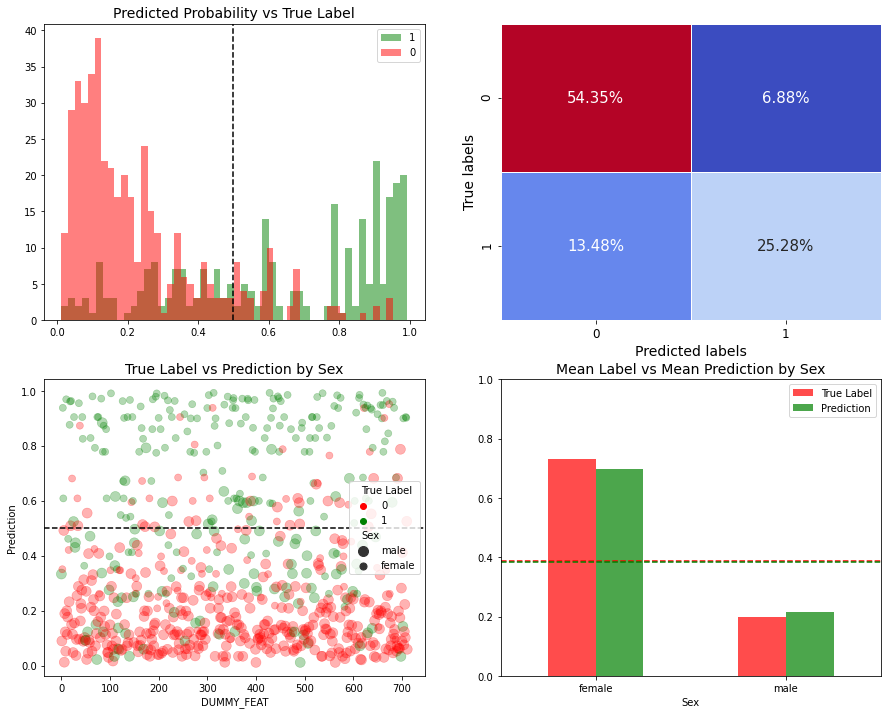

Accuracy score: 	0.7963
AUC ROC: 		0.8667
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       436
           1       0.79      0.65      0.71       276

    accuracy                           0.80       712
   macro avg       0.79      0.77      0.78       712
weighted avg       0.80      0.80      0.79       712



In [49]:
models = [('logit', LogisticRegression()), 
          ('forest', RandomForestClassifier(n_estimators=200)), 
          ('tree', DecisionTreeClassifier(max_depth=5)), 
          ('xgb', xgb.XGBClassifier(n_estimators=2000, use_label_encoder=False)), 
          ('lgb', lgb.LGBMClassifier(n_estimators=2000))]

proc = Pipeline([('dummy', tml.Dummify(drop_first=True))])

compare_models(train[train_feats], y, models, kfolds, processing=proc)

# Imputing missing values

In [50]:
train_feats = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']

logit


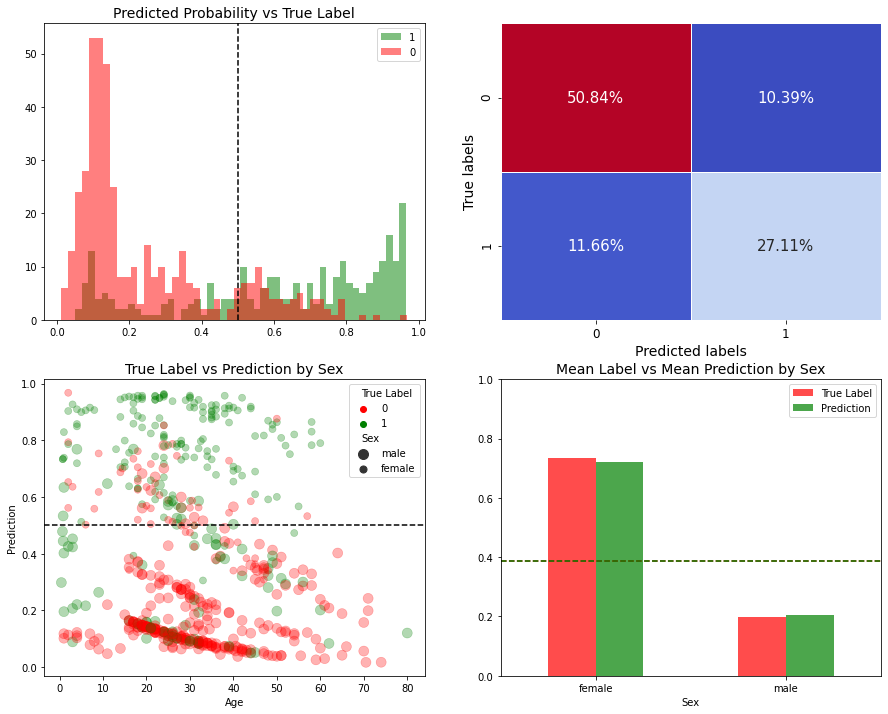

Accuracy score: 	0.7795
AUC ROC: 		0.838
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       436
           1       0.72      0.70      0.71       276

    accuracy                           0.78       712
   macro avg       0.77      0.76      0.77       712
weighted avg       0.78      0.78      0.78       712

forest


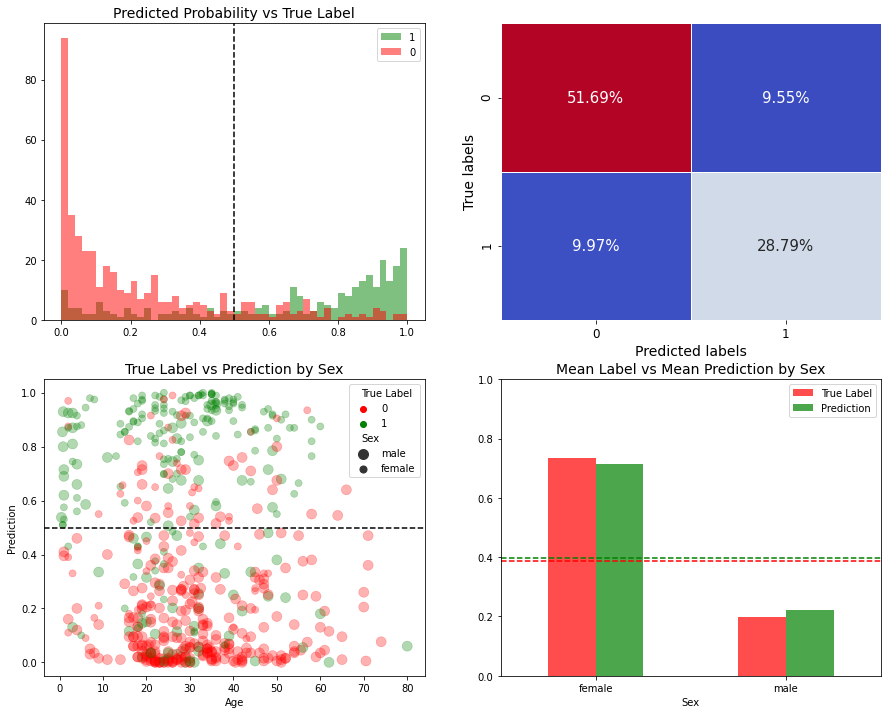

Accuracy score: 	0.8048
AUC ROC: 		0.8515
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       436
           1       0.75      0.74      0.75       276

    accuracy                           0.80       712
   macro avg       0.79      0.79      0.79       712
weighted avg       0.80      0.80      0.80       712

tree


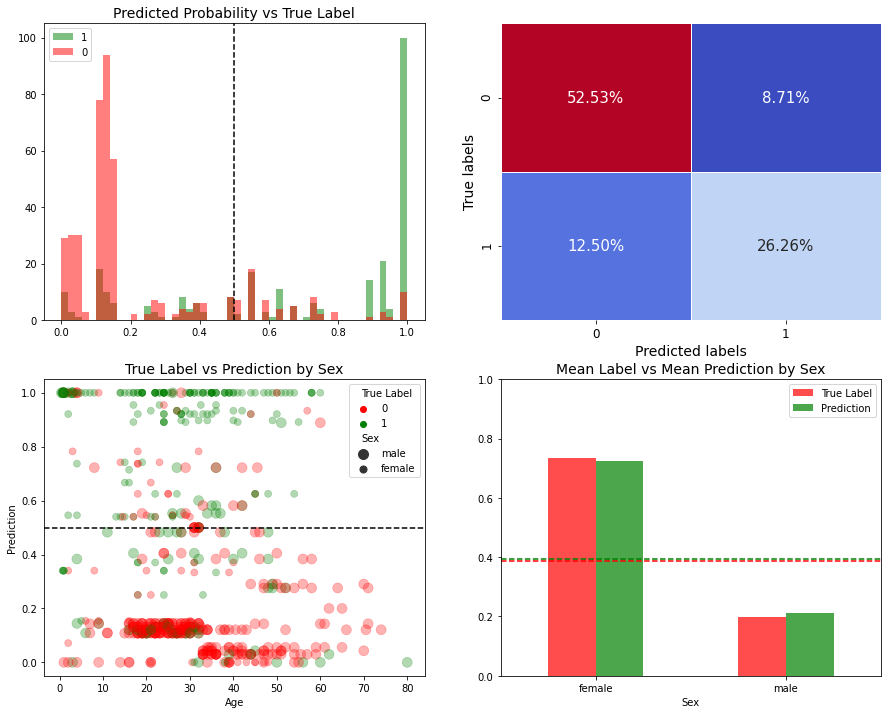

Accuracy score: 	0.7809
AUC ROC: 		0.8268
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       436
           1       0.73      0.68      0.71       276

    accuracy                           0.78       712
   macro avg       0.77      0.76      0.77       712
weighted avg       0.78      0.78      0.78       712

xgb


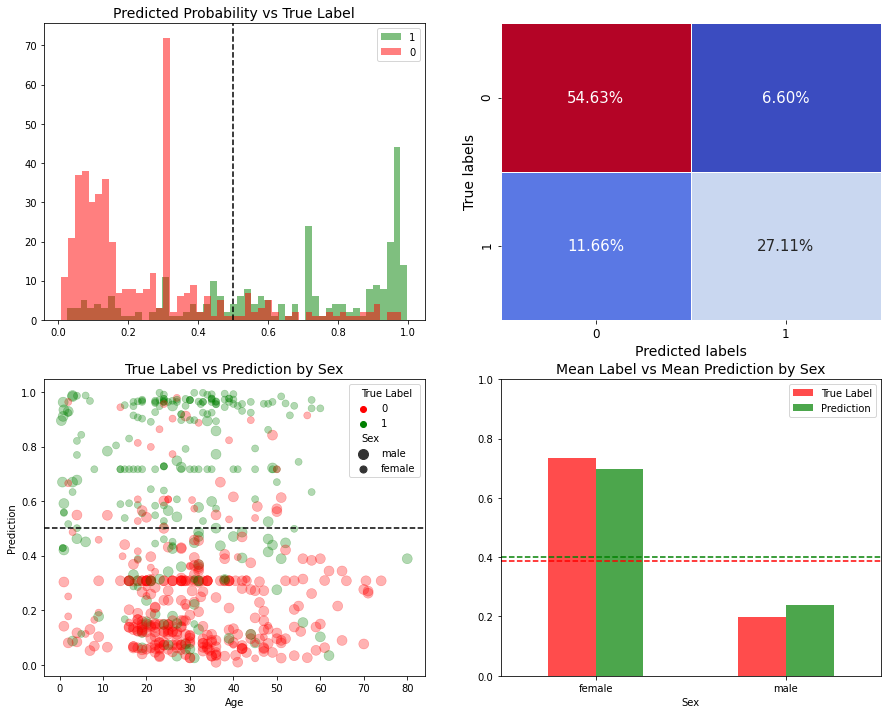

Accuracy score: 	0.8174
AUC ROC: 		0.8634
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       436
           1       0.80      0.70      0.75       276

    accuracy                           0.82       712
   macro avg       0.81      0.80      0.80       712
weighted avg       0.82      0.82      0.81       712

lgb


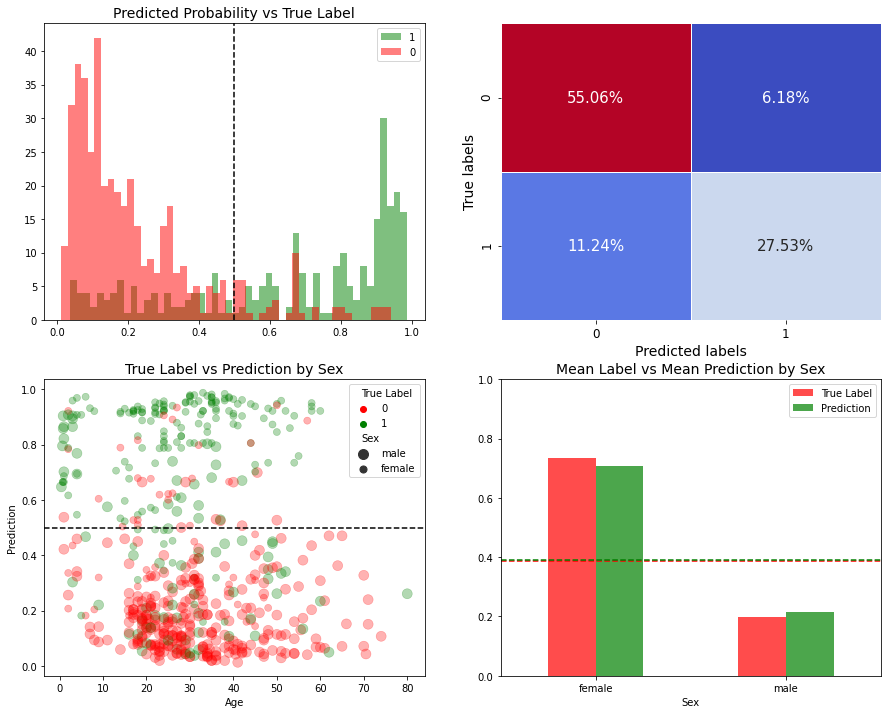

Accuracy score: 	0.8258
AUC ROC: 		0.8719
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       436
           1       0.82      0.71      0.76       276

    accuracy                           0.83       712
   macro avg       0.82      0.80      0.81       712
weighted avg       0.83      0.83      0.82       712



In [51]:
models = [('logit', LogisticRegression(max_iter=5000)), 
          ('forest', RandomForestClassifier(n_estimators=200)), 
          ('tree', DecisionTreeClassifier(max_depth=5)), 
          ('xgb', xgb.XGBClassifier(n_estimators=2000, use_label_encoder=False)), 
          ('lgb', lgb.LGBMClassifier(n_estimators=2000))]

num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', tml.DfImputer(strategy='median'))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', tml.DfImputer(strategy='most_frequent')), 
                     ('dummy', tml.Dummify(drop_first=True))])


proc = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), ('cat', cat_pipe)])

compare_models(train[train_feats], y, models, kfolds, processing=proc)